In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from IPython import display


# 讀懂客戶的心 (pytorch)

![Alt text](../images/readmind.jpg)

文字是人類表達心中想法的工具，也因此要讀懂客戶的心的最快方式就是閱讀客戶的評論。在過去我們通常使用以詞為基礎的lstm進行建模，但是分詞的過程以及辭典外詞彙(OOV)經常造成困擾之外，LSTM難以收斂以及不能平行計算也是一個煩人的問題。在這個實作中，我們將帶各位使用一維卷積進行序列對序列分析，覺得卷積神經網路跨界有點遠?別忘記了，相較於西歐的拼音文字，中文的本質其實就是圖片，使用卷積神經網路可以透過空洞卷積來擴大感知域，來達到類似LSTM的上下文記憶，它最大的好處就在於它完全可以平行計算加速。至於效果如何，我們就來看看實作的成效囉。  



In [2]:
import glob
import os
import cv2
os.environ['TRIDENT_BACKEND'] = 'pytorch'
#!pip install tridentx --upgrade
import trident as T
from trident import *
import numpy as np
import string
import pickle



trident 0.6.0


Using Pytorch backend.
Image Data Format: channels_first.
Image Channel Order: rgb.
Using pillow image backend.


Pillow version:7.1.2.


Pytorch version:1.6.0+cu101.
Automatic Mixed Precision Support:True.


在本次實作中，我們的案例是一家速食業者，他透過爬蟲抓取客戶的反饋，我們根據正面、負面、中性對應至**價格、品質、服務、環境與其他**五大面向，進行客戶評論的「逐字標註」，以挖掘客戶的態度，對應代碼如下。

In [3]:
mapping={
"無":"0",
"價格正面":"A",
"價格中性":"B",
"價格負面":"C",
"品質正面":"D",
"品質中性":"E",
"品質負面":"F",
"服務正面":"G",
"服務中性":"H",
"服務負面":"I",
"環境正面":"J",
"環境中性":"K",
"環境負面":"L",
"其他正面":"M",
"其他中性":"N",
"其他負面":"O"}


我們首先讀取一下語料

In [4]:
data=open('corpus_tw.txt',encoding='utf-8-sig').readlines()
for text in data[:10]:
    print(text)

1	只要10塊錢。	AAAAAAA

2	這個價格在火車站來說已經很親民了。	000000000000MMMM0

3	而且味道也好。	00DDDDD

4	很清淡。	DDDD

5	啦啦。	000

6	以后要經常來吃。	MMMMMMM0

7	味道不錯，蠻好吃的，😘😘😘😘😘。	DDDDDDDDDDMMMMMM

8	還可以就是點啥都沒有了，很被動的。	000000000000OOOO0

9	臘雞，千萬不要吃，快餐還是選擇肯德基和麥當勞，不知道放了多久的東西就拿出來賣，去反映還要跟我說他家就是這樣的，臘雞。	00000FFFF0000000000000000000000000000000000000000000000000

10	脆皮大雞腿，味道挺好吃的。	00000000DDDD0



為了評估適合的序列最大長度，我們統計一下，評論的長度分布。

(array([2.0807e+04, 6.5630e+03, 1.6580e+03, 7.2200e+02, 7.5800e+02,
        2.8400e+02, 1.4300e+02, 6.7000e+01, 1.5000e+01, 8.0000e+00]),
 array([2.0000e+00, 2.6800e+01, 5.1600e+01, 7.6400e+01, 1.0120e+02,
        1.2600e+02, 1.5080e+02, 1.7560e+02, 2.0040e+02, 2.2520e+02,
        2.5000e+02]),
 <a list of 10 Patch objects>)

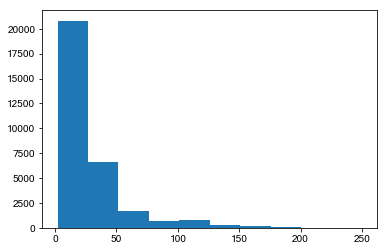

In [5]:
lengths=np.array([len(text.split('\t')[1]) for text in data])
counts, bins = np.histogram(lengths)
plt.hist(bins[:-1], bins, weights=counts)

像是評論這種網路語料通常清洗起來比較麻煩，而且常常充滿各種無效字元，所以建議要先經過處理，例如中文最常見的就是全形半形轉換，建議全部轉為半形。

In [6]:
#全形轉半形
def str_full_to_half(in_str):
    out_str = []
    for char in in_str:
        inside_code = ord(char)
        if inside_code == 0x3000 or inside_code == 12288 or char == string.whitespace:  # 全形空格直接轉換
            out_str.append(' ')
        elif inside_code >= 65281 and inside_code <= 65374:
            inside_code -= 0xfee0
            out_str.append(chr(inside_code))
        else:
            out_str.append(char)

    return ''.join(out_str)


在提供的語料中，每一列可以用分隔符號分成三個區段，分別為序號，評論內容以及評論標註，我們將評論內容與標註分開收集後，就可以餵入load_text以產生我們序列數據的data_provider。

In [7]:
new_data=[]
new_tag=[]
for raw in tqdm(data):
    cols=raw.strip().split('\t')
    idx=cols[0]
    content=str_full_to_half(cols[1].strip())
    tag=cols[2]
    if len(content)==len(tag):
        new_data.append(content)
        new_tag.append(tag)
    else:
        print(content,len(content),tag,len(tag))



data_provider=load_text(data=new_data, label=new_tag,unit='char',mode='1to1_seq2seq',is_onehot=False,sequence_length=250,sequence_start_at='section_start')
t1,t2=data_provider.next()
print(data_provider.signature)


100%|█████████████████████████████████████████████████████████████████████████| 31025/31025 [00:00<00:00, 54101.32it/s]


total distinct chars: 3459
total distinct chars: 21
data_provider( ) -> input: Tensor[(-1, 250)], label: Tensor[(-1, 250)] 


我們將數據與標籤透過data_provider.index2text以及data_provider.index2label轉換為文字，列印一下，來確認輸出序列是否正確。同時透過查閱data_provider的vocabs以及label_vocabs，就能確認輸入字數以及輸出標籤類別數了，但別忘記，系統會自動加入一些輔助符號，為了確認後續進行遮罩的起點，我們可以透過data_provider.label2index反查一下有意義的標籤的起始索引。

In [8]:
for k in range(3):
    print(''.join([data_provider.index2text(i) for i in t1[k]]))
    print(''.join([data_provider.index2label(i) for i in t2[k]]))
    print('')

    
print('')
print(''.join(data_provider.vocabs))
print('')
print(''.join(data_provider.label_vocabs))
print('')
print(data_provider.label2index('A'))




<start/>第一次來銀杏湖玩,吃的東西好貴,就德克士不錯,就來了,里面很干凈,一看就是新店,東西也很好吃,都是現做出來的,阿姨很熱心,上一桌吃完剛走,我們坐下來,阿姨就立刻把垃圾都收走了。<end/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad/><pad

接下來是定義TextCNN的結構，請注意，因為是一對一的Seq2Seq，所以全程不使用strides>1，以確保整體長度不變。

In [9]:

textcnn=Sequential(
        Embedding(embedding_dim=256,num_embeddings=len(data_provider.vocabs),sparse=False,name='embed'),
        Permute(0,2,1),
        ConcateBlock(
            Sequential(
                Conv1d_Block(kernel_size=3,num_filters=512,strides=1,auto_pad=True,activation='leaky_relu',normalization='batch',dilation=1,dropout_rate=0.1),
                Conv1d_Block(kernel_size=3,num_filters=256,strides=1,auto_pad=True,activation='leaky_relu',normalization='batch')
            ),
            Sequential(
                Conv1d_Block(kernel_size=5,num_filters=512,strides=1,auto_pad=True,activation='leaky_relu',normalization='batch',dilation=1,dropout_rate=0.1),
                Conv1d_Block(kernel_size=3,num_filters=256,strides=1,auto_pad=True,activation='leaky_relu',normalization='batch')
            ),
            Sequential(
                Conv1d_Block(kernel_size=7,num_filters=512,strides=1,auto_pad=True,activation='leaky_relu',normalization='batch',dilation=1,dropout_rate=0.1),
                Conv1d_Block(kernel_size=3,num_filters=256,strides=1,auto_pad=True,activation='leaky_relu',normalization='batch')
            ),
            Sequential(
                Conv1d_Block(kernel_size=3,num_filters=512,strides=1,auto_pad=True,activation='leaky_relu',normalization='batch',dilation=3,dropout_rate=0.1),
                Conv1d_Block(kernel_size=3,num_filters=256,strides=1,auto_pad=True,activation='leaky_relu',normalization='batch')
            ),
            Sequential(
                Conv1d_Block(kernel_size=3,num_filters=512,strides=1,auto_pad=True,activation='leaky_relu',normalization='batch',dilation=6,dropout_rate=0.1),
                Conv1d_Block(kernel_size=3,num_filters=256,strides=1,auto_pad=True,activation='leaky_relu',normalization='batch')
            )
        ),
        Conv1d_Block(kernel_size=3,num_filters=256,strides=1,auto_pad=True,activation='leaky_relu',normalization='batch'),
        Conv1d_Block(kernel_size=3,num_filters=64,strides=1,auto_pad=True,activation='leaky_relu',normalization='batch'),
        Conv1d_Block(kernel_size=1,num_filters=len(data_provider.label_vocabs),strides=1,auto_pad=True,activation=None),
        SoftMax(axis=1)
    )


由於最大序列長度為250，所以大多數的評論序列後方都是<PAD/>符號，這些大量的填充符號若是一起參與建模，恐怕它數量上的優勢會不利於建模收斂，因此我們需要進一步將損失函數與評估函數都加上遮罩，去除掉他們的影響。

In [10]:
#加入遮罩的正確率
def accuracy_exclude_mask(output, target):
    output=argmax(output,1)
    mask = (output>=6)
    masked_output=output[mask]
    masked_target=target[mask]
    return reduce_mean(equal(cast(masked_output,'float32'),cast(masked_target,'float32')))

#加入遮罩的召回率
def recall_exclude_mask(output, target):
    output = argmax(output, 1)
    mask = (target>=6)
    masked_output=output[mask]
    masked_target=target[mask]
    return  reduce_mean(equal(cast(masked_output,'float32'),cast(masked_target,'float32')))

#加入遮罩的CrossEntropyLoss
def crossentropy_exclude_mask(output, target):
    mask = greater_equal(target,6)
    masked_output=output*(expand_dims(mask,1))
    masked_target=cast(target*mask,'long')
    loss_sum=CrossEntropyLoss(reduction='sum',axis=1)(masked_output,masked_target)+CrossEntropyLoss(reduction='sum',axis=1)(output,cast(target,'long'))
    return loss_sum.sum()#/mask.sum()


同時為了確保輸出結果是正確的，我們讓模型每跑500次，就列印一次推論結果，我們在此使用trigger_when這個新功能，就可以簡單的定義一個函數就能遷入到訓練流程中。

In [11]:
def test_reading(training_context):
    """

    :param training_context:
    :type training_context:
    """
    global data_provider
    epoch = training_context['current_epoch']
    batch = training_context['current_batch']
    num_batch = training_context['total_batch']
    if (epoch * num_batch + batch+1)% 500 == 0:
        model =copy.deepcopy( training_context['current_model'])
        # 模型千萬記得要轉換成eval模式
        model.eval()
        data_feed=training_context['data_feed']
        training_data=training_context['train_data']

        input=training_context['train_data'][data_feed[model.signature.inputs.key_list[0]]].to(model.device)
        output=argmax(model(input),1)

        for k in range(3):
            in_text=[data_provider.index2text(i) for i in to_numpy(input[k])]
            out_text=[data_provider.index2label(i) for i in to_numpy(output[k])]
            idx=in_text.index('<pad/>')
            print(''.join(in_text[:idx]))
            print(''.join(out_text[:idx]))
            print('')



model = Model(inputs=t1, output=textcnn) \
    .with_optimizer(optimizer='Ranger', lr=2e-3, betas=(0.9, 0.999)) \
    .with_loss(crossentropy_exclude_mask, loss_weight=1, name='cross entropy') \
    .with_metric(accuracy_exclude_mask, name='accuracy') \
    .with_metric(recall_exclude_mask, name='recall') \
    .with_regularizer('l2') \
    .with_constraint('min_max_norm') \
    .trigger_when('on_batch_end', action=test_reading) \
    .with_learning_rate_scheduler(reduce_lr_on_plateau, monitor='accuracy', mode='max', factor=0.75, patience=5, cooldown=1, threshold=1e-4, warmup=0) \
    .with_model_save_path('Models/textcnn.pth') \
    .with_automatic_mixed_precision_training()

model.summary()


cross entropy( output, target) -> cross entropy 
accuracy( output, target) -> accuracy 
recall( output, target) -> recall 
Automatic Mixed Precision:Turn On.
--------------------------------------------------------------------------------------------------------------------------------
              Layer (type)                   Output Shape            Weight           Bias    Param #     FLOPS #   
embed                                    [-1, 250, 256]        [3459, 256]                    885504    453377792.0 
1                                        [-1, 256, 250]                                       0         0.0         
2.branch1.0.conv                         [-1, 512, 250]        [512, 256, 3]                  393216    196607750.0 
2.branch1.0.norm                         [-1, 512, 250]        [512]                [512]     1024      383750.0    
2.branch1.0                              [-1, 512, 250]                                       0         0.0         
2.branch1.1

最後，把模型與數據提供者整合至學習計畫，就可以進行訓練了。

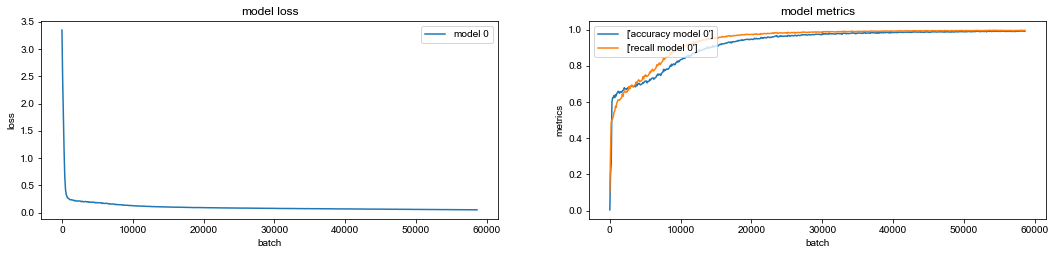

model 0      Step: 37s706ms | Loss: 0.05321 | accuracy: 98.984% ,recall: 99.419%  | learning rate: 2.000e-03 | epoch: 60  ( 500/970 )
model 0      Step: 35s320ms | Loss: 0.05281 | accuracy: 99.065% ,recall: 99.531%  | learning rate: 2.000e-03 | epoch: 60  ( 600/970 )


In [ ]:

plan=TrainingPlan()\
    .add_training_item(model)\
    .with_data_loader(data_provider)\
    .repeat_epochs(100)\
    .within_minibatch_size(32)\
    .print_progress_scheduling(100,unit='batch')\
    .display_loss_metric_curve_scheduling(frequency=500,unit='batch',imshow=True)\
    .print_gradients_scheduling(500)\
    .save_model_scheduling(200,unit='batch')  

plan.start_now()
